# fMRI Deconvolution Toolbox

Tutorial script to get started with the toolbox. 
Currently, the toolbox only supports two conditions that are alternating in a sequence such as A-B-A-B-A-B... where A and B represent a cue and a target respectively, similiar to attention related fMRI designs (Hopfinger 2000, Kastner 1999).

A future release will include support for multiple stimuli in a trial similar to a event related trial by trial fMRI design.  
&nbsp;  
*Authors: Soukhin Das (UC Davis) & Weigang Yi (UC Davis), 2022*

# Example to Test Different Combinations of Parameters in timecourses
This example demonstrates how to use the different functions in this toolbox to determine the optimal parameters for the fMRI timecourses.


# Table of Contents
* [Import necessary packages](#packages)
* [Load the Noise file](#introduction)
* [Specify parameters](#generate_tcs)
* [Pull out the generated timecourses](#timecourses)
* [Characterize the average evoked response for an event](#average_epoch)
* [Calculate the optimality measures for the generated timecourses](#optimality)
* [Calculate weighted optimality measures](#w_optimality)
* [References](#refs)


## Import necessary packages <a name="packages"></a>
The following cell block imports necessary modules from the toolbox to get started with.

In [512]:
import deconvolve
from tools import plotfs


## Load the Noise file <a name="introduction"></a>
We start by loading in any 4D MRI rest scan file that can be readable by nibabel./n
Provide the path to the rest scan as input to the ```path``` variable.

In the backend, the file is loaded followed by extraction of different noise parameters from the signal using fMRIsim (Ellis et. al. 2020): physiological noise related to cardiac and respiratory activity, head/body movements, system and task-related noise, drift and autoregressive/ moving average (AMRA) noise related to the machine

/Users/sdas/Desktop/deconv/fmrisim_modified.py:1388: RuntimeWarning: Mean of empty slice
  auto_reg_rho = np.nanmean(auto_reg_rho_all, 0).tolist()
/Users/sdas/Desktop/deconv/fmrisim_modified.py:1389: RuntimeWarning: Mean of empty slice
  ma_rho = np.nanmean(ma_all, 0).tolist()
/Users/sdas/Desktop/deconv/fmrisim_modified.py:1388: RuntimeWarning: Mean of empty slice
  auto_reg_rho = np.nanmean(auto_reg_rho_all, 0).tolist()
/Users/sdas/Desktop/deconv/fmrisim_modified.py:1389: RuntimeWarning: Mean of empty slice
  ma_rho = np.nanmean(ma_all, 0).tolist()
/Users/sdas/Desktop/deconv/fmrisim_modified.py:1388: RuntimeWarning: Mean of empty slice
  auto_reg_rho = np.nanmean(auto_reg_rho_all, 0).tolist()
/Users/sdas/Desktop/deconv/fmrisim_modified.py:1389: RuntimeWarning: Mean of empty slice
  ma_rho = np.nanmean(ma_all, 0).tolist()
/Users/sdas/Desktop/deconv/fmrisim_modified.py:1388: RuntimeWarning: Mean of empty slice
  auto_reg_rho = np.nanmean(auto_reg_rho_all, 0).tolist()
/Users/sdas/Desktop

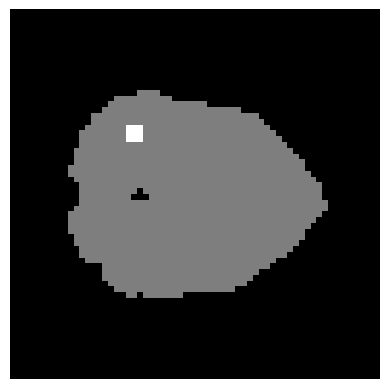

In [513]:
path = "/Users/sdas/Desktop/Participant_03_rest_run02.nii"
lv = deconvolve.load_noise(path)

## Specify parameters to generate timecourses <a name="generate_tcs"></a>

Next, during this critical step, provide parameters of the timecourses that is to be generated for further analyses.
The function ```run_experiment``` takes inputs as a ```dict``` of parameters. The important fields are specified and described as follows:

* The first two parameters specify the upper limits of the **lower ISI** and **upper ISI** respectively. It will iterate all possible combinations until the limits. By default, they are set upto ```20``` seconds each.

* ```lv``` carries information about the noise extracted from the rest scan.

* ```event_duration```: **Duration** of each event in seconds. By default, it is set to 0.1 seconds.  
* ```signal_mag```: This is an internal reference to fMRIsim to scale the signals with respect to baseline/ noise signal.  
* ```distribution```: **Probability distribution of jitter** Specify from, ```uniform / stochastic_rapid / stochastic_interm / stochastic_slow / exp```  
    - ```Uniform```: equal probability distribution of ISI jitters between the L_ISI and U_ISI.  
    - ```Stochastic_xxx```:  stochastic probability distribution of ISI jitters between the L_ISI and U_ISI.  
    - ```exp```:  exponential probability distribution of ISI jitters between the L_ISI and U_ISI.  
&nbsp;  
* ```dist_param```: **Distribution parameter**. Usually set to ```None```, this can be used in case the default distribution parameters does not work.  
* ```stim_ratio```: **Stimulus ratio**. It sets the relative amplitude of event A with respect to B. Ranges between ```0-1```.
    - 0 &nbsp;&nbsp;&nbsp;= A is 0 times smaller than B
    - 0.5 = A is 0.5 times smaller than B
    - 1 &nbsp;&nbsp;&nbsp;&nbsp;= A is equal to B  
&nbsp;  
* ```noise```: Set to ```True``` if realistic noise is to be added to the output, else set to ```False```.
* ```nonlinear```: Set to ```True``` if the timecourses should be modelled using nonlinear interactions (Friston 2000), else set to ```False```.  
* ```null_ratio```: **Null events ratio**. It sets a ratio of B events to null. Ranges between ```0-1```.
    - 0.1 = 10% of B events are set to null.
    - 0.2 = 20% of B events are set to null.
    - 0.5 = 50% of B events are set to null.
    
* ```transiet_load```: **Maintenance Like Activity***. 
    - ```attn```: include maintenance like activity during intervals related to selective attention.
    - ```wm```: include maintenance like activity during intervals related to working memory.  
&nbsp;  
* ```hrf_type```: **HRF** to convolve the events with.
    - ```double_gamma```: Use the canonical hemodynamic response function.
    - ```square```: Use a square wave as the HRF.
    - ```custom```: Use the canonical hemodynamic response function using **custom** parameters.
        - ```response_delay``` = How many seconds until the peak of the HRF
        - ```undershoot_delay``` = How many seconds until the trough of the HRF
        - ```response_dispersion``` = How wide is the rising peak dispersion
        - ```undershoot_dispersion``` = How wide is the undershoot dispersion
        - ```response_scale``` = How big is the response relative to the peak
        - ```undershoot_scale``` = How big is the undershoot relative to the trough  
&nbsp;

Upon execution, the output shows the time elapsed and a plot representing the probability distribution of the jitter that was used.


Time elapsed: 13.64139699935913


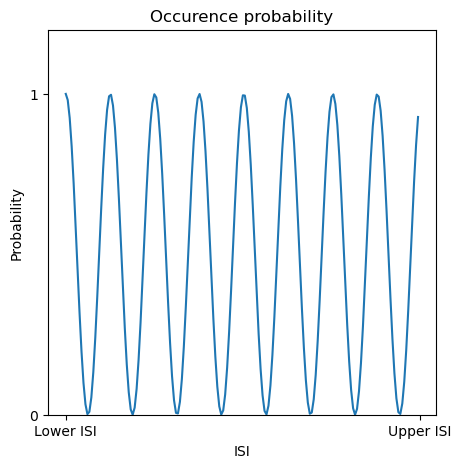

In [526]:
import importlib
importlib.reload(deconvolve)
parameters = {
                "event_duration" : 0.1,
                "signal_mag": [2],
                "distribution" : "stochastic_rapid",
                "dist_param" : None,
                "stim_ratio" : 1,
                "noise" :  False,
                "nonlinear" : True,
                "null_ratio": None,
                "transient_load":None,
                "hrf_type":"double_gamma",
                "hrf_params":None
             }
lim_lisi = 20
lim_uisi = 20
# The first parameter below is the upper bound of the lower isi, the second parameter is the upper bound of the upper isi.
p1, p2, result = deconvolve.run_experiment(lim_lisi, lim_uisi, lv, parameters)

## Pull out the generated timecourses <a name="timecourses"></a>

The function ```graph_timecourses``` plots the timecourses during the specified bounds of the ISIs.  
Pass the lower and upper bounds of ISIs as pairs using the ```ISIs``` variable.  
For this particular example, we are interested in the timecourses that have ISIs between (2-3s), (5-9s), (2-19s), (18-19s) and (2-10s).
&nbsp;  

```xlim``` sets the length of output in TRs in x-axis.  
```ylim``` sets the length of amplitude in y-axis.


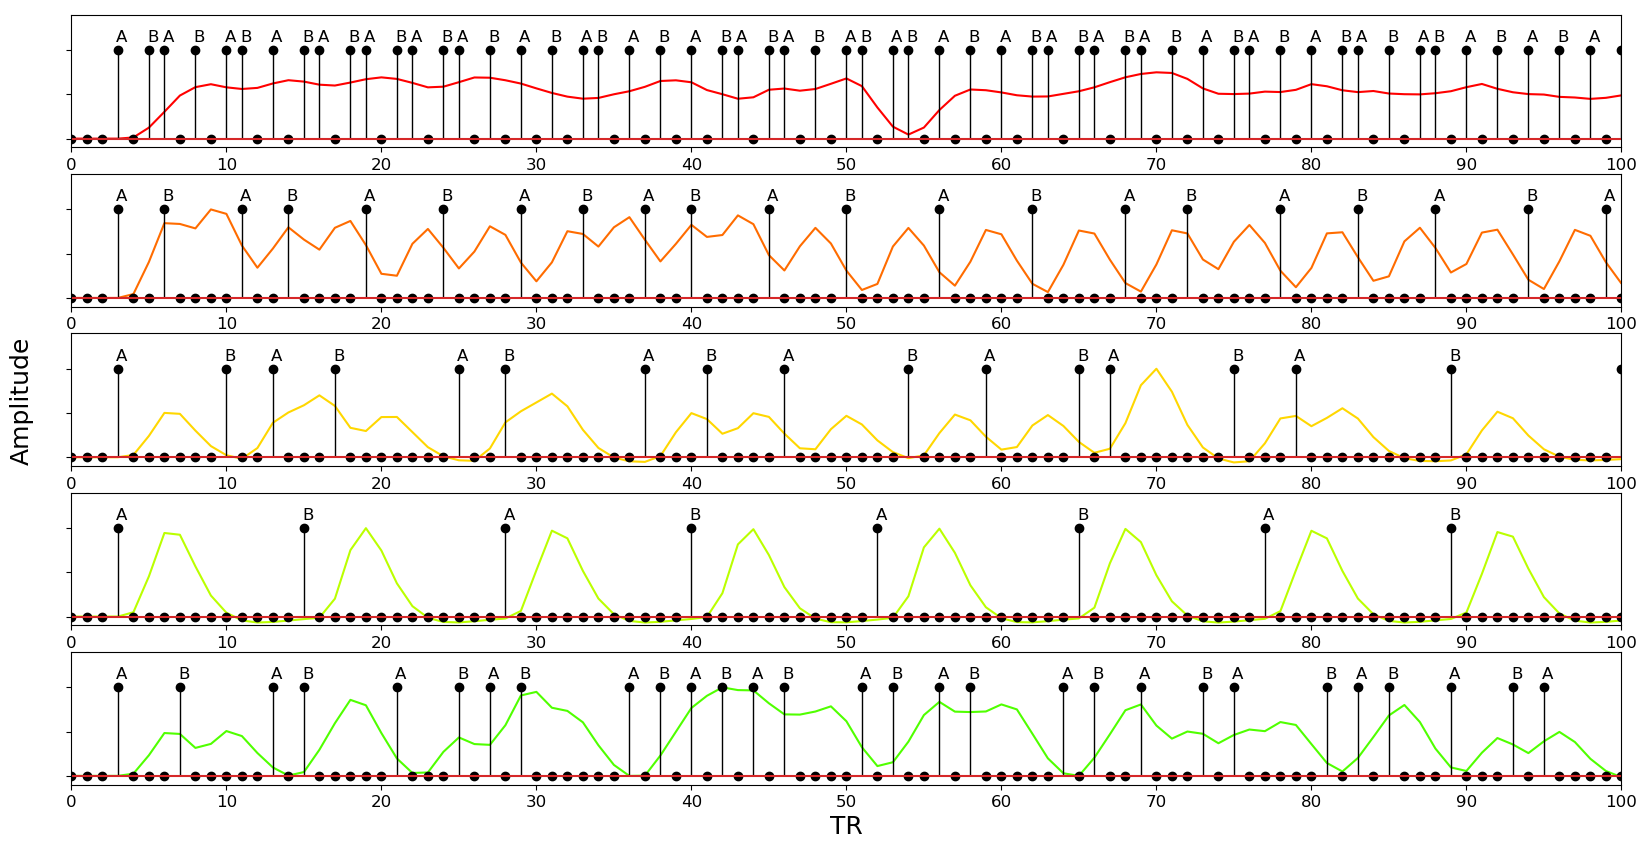

In [527]:
ISIs = [ 
        [ 2, 3 ],
        [ 5, 9 ],
        [ 2, 19 ],
        [ 18, 19 ],
        [ 2, 10 ] 
       ]
fig = plotfs.graph_timecourses(result, ISIs, stimuli = [ 'A', 'B' ], xlim = 100, ylim = 1.2)

## Characterize the average evoked response for an event <a name="average_epoch"></a>

The ```plot_avg_response``` function takes in the output from the ```run_experiment``` function and plots averaged epochs of timecourses. This helps visualizing the raw timecourse of an event and determine if and how it is convolved with neighbouring events.  

The following example plots the timecourse when lower_isi is set to 7 and upper isi is set to 18 for event A:
```
plotfs.plot_avg_response(result['7']['18']['t1'], result['7']['18']['e'])
```
This example plots the timecourse when lower_isi is set to 2 and upper isi is set to 9 for event B:
```
plotfs.plot_avg_response(result['2']['9']['t2'], result['2']['9']['e'])

```

Optional arguements, ```before``` and ```after``` can be specifified to change the length of epoch to -before TRs and +after TRs around 0 as follows:
```
plotfs.plot_avg_response(result['2']['9']['t2'], result['2']['9']['e'],before = 2, after = 12)

```

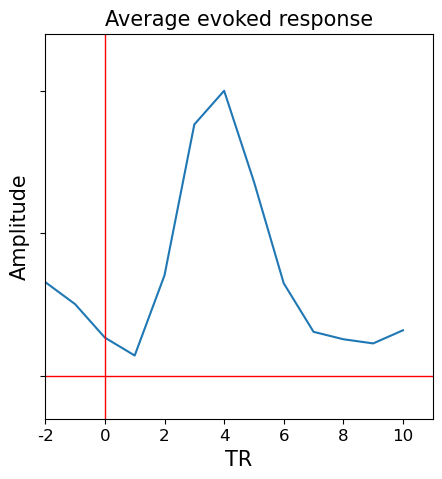

In [528]:
plotfs.plot_avg_response(result['7']['18']['t1'], result['7']['18']['e'])

## Calculate the optimality measures for the generated timecourses <a name="optimality"></a>
The ```plot_result``` function takes in two arguements, ```p1``` and ```p2```, obtained from the ```run_experiment``` function and shows the detection power and estimation efficiency of the designs.

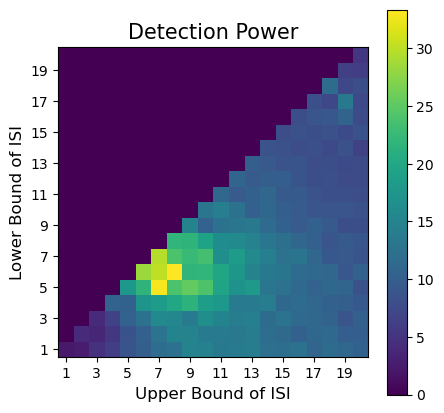

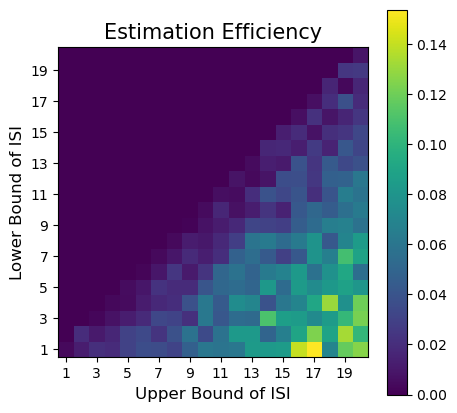

In [529]:
fig = plotfs.plot_result(p1, p2)

## Calculate weighted optimality measures <a name="w_optimality"></a>

This particular function ```plot_weighted_result``` takes in the previous arguements ```p1``` and ```p2``` obtained from ```run_experiment``` and an extra arguement ```w```.  
```w``` is passed as a 1x2 array ```[w1, w2]```.  
It sets weights- ```w1``` to detection power and ```w2``` to estimation efficiency and combines the two measures to generate a common optimality plot.

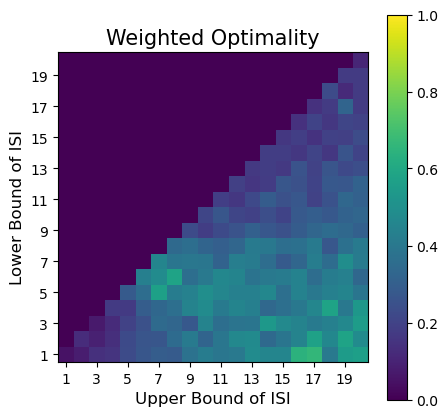

In [533]:
fig1 = plotfs.plot_weighted_result(p1,p2,[0.5 , 0.5])

 ## References <a name="refs"></a>
1. Ellis, C. T., Baldassano, C., Schapiro, A. C., Cai, M. B., & Cohen, J. D. (2020). Facilitating open-science with realistic fMRI simulation: validation and application. PeerJ, 8, e8564. https://doi.org/10.7717/peerj.8564

2. Friston, K. J., Josephs, O., Rees, G., & Turner, R. (n.d.). Nonlinear Event-Related Responses in fMRI. 41–52.

3. Friston, K. J., Zarahn, E., Josephs, O., Henson, R. N. A., & Dale, A. M. (1999). Stochastic designs in event-related fMRI. NeuroImage, 10(5), 607–619. https://doi.org/10.1006/nimg.1999.0498